# Keyword transformation

A linear transformation of keywords from SHARP_LOS to SMARP.

Code adapted from https://github.com/mbobra/smarp/blob/master/figures/Figure3.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR, Lasso
from sklearn.model_selection import train_test_split
import drms

In [2]:
email = 'szymails@gmail.com'
c = drms.Client(debug=True, verbose=True, email=email)

http://jsoc.stanford.edu/cgi-bin/ajax/checkAddress.sh?address=szymails%2540gmail.com&checkonly=1


### Find all the NOAA active regions that appear in both the SMARP and SHARP database

In [3]:
# SHARP and SMARP overlap period
t_start = '2010.05.01_00:00:00_TAI'
t_end = '2010.10.28_00:00:00_TAI'

Construct the queries to identify all the active regions during the overlap period that have a NOAA active region number (`NOAA_ARS <> \'MISSING\'`) and more than 10 observations (`N_PATCH1 > 10`).

The SHARP series have a few keywords that define the beginning and end of a HARP's lifetime: `T_FRST1` and `T_LAST1`. The SMARP series has an additional keyword, `T_MID1`. It identifies the mid-point record of each `HARPNUM` or `TARPNUM`. Using the clause `T_MID1=T_REC` or `T_FRST1=T_REC` selectes only one record per TARPNUM. This is appropriate because the keywords `NOAA_ARS` and `NPATCH_1` are constant per `TARPNUM`.

In [4]:
hmi_query_string = 'hmi.sharp_cea_720s[]['+t_start+'-'+t_end+'][? (T_FRST1=T_REC) AND (NOAA_ARS <> \'MISSING\') AND (N_PATCH1 > 10) ?]'
khmi = c.query(hmi_query_string, key='NOAA_ARS,HARPNUM')

mdi_query_string = 'su_mbobra.smarp_cea_96m[]['+t_start+'-'+t_end+'][? (T_MID1=T_REC) AND (NOAA_ARS <> \'MISSING\') AND (N_PATCH1 > 10) ?]'
kmdi = c.query(mdi_query_string, key='NOAA_ARS,TARPNUM')

# Drop all rows that have a missing NOAA active region number
khmi = khmi.drop(khmi.index[khmi['NOAA_ARS'] == 'MISSING']);
kmdi = kmdi.drop(kmdi.index[kmdi['NOAA_ARS'] == 'MISSING']);

keys = pd.merge(khmi, kmdi, on='NOAA_ARS')
keys

http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B%5D%5B2010.05.01_00%3A00%3A00_TAI-2010.10.28_00%3A00%3A00_TAI%5D%5B%3F+%28T_FRST1%3DT_REC%29+AND+%28NOAA_ARS+%3C%3E+%27MISSING%27%29+AND+%28N_PATCH1+%3E+10%29+%3F%5D&key=NOAA_ARS%2CHARPNUM
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=hmi.sharp_cea_720s
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=su_mbobra.smarp_cea_96m%5B%5D%5B2010.05.01_00%3A00%3A00_TAI-2010.10.28_00%3A00%3A00_TAI%5D%5B%3F+%28T_MID1%3DT_REC%29+AND+%28NOAA_ARS+%3C%3E+%27MISSING%27%29+AND+%28N_PATCH1+%3E+10%29+%3F%5D&key=NOAA_ARS%2CTARPNUM
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=su_mbobra.smarp_cea_96m


,NOAA_ARS,HARPNUM,TARPNUM
0,11067,1,13395
1,11064,2,13394
2,11069,8,13404
3,11066,10,13400
4,11063,11,13401
5,11068,12,13402
6,11070,14,13410
7,11072,26,13433
8,11073,38,13451
9,11075,40,13454


### Plot all of the spaceweather keyword values for these common active regions

Query all the spaceweather keyword metadata for the common NOAA active regions identified above. Select all records where:
1. The same `T_REC` appears in both the SMARP and SHARP data,
2. The HARP or TARP is within 70 degrees of central meridian, and
3. The data are of good quality (`(QUALITY<262144)` for SMARP and `(QUALITY<65536)` for SHARP).

Note that here we are querying the keyword-only series su_mbobra.sharp_loskeys_720s.

In [5]:
list_of_dataframes = []

for i in range(len(keys)):
    HARPNUM = str(keys['HARPNUM'][i])
    TARPNUM = str(keys['TARPNUM'][i])

    print('Gathering data for HARPNUM', HARPNUM, 'and TARPNUM', TARPNUM)

    # query all records for this harpnum
    hmi_query_string = 'su_mbobra.sharp_loskeys_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmilos = c.query(hmi_query_string, key='T_REC,HARPNUM,USFLUX,MEANGBZ,R_VALUE,INSTRUME')

    hmi_query_string = 'hmi.sharp_cea_720s['+HARPNUM+'][][? (QUALITY<65536) ?]'
    khmivec = c.query(hmi_query_string, key='T_REC,NOAA_ARS,CRVAL1,CRLN_OBS,TELESCOP,USFLUX,MEANGBZ,R_VALUE')

    # query all records for this tarpnum
    mdi_query_string = 'su_mbobra.smarp_cea_96m['+TARPNUM+'][][? (QUALITY<262144) ?]'
    kmdi = c.query(mdi_query_string, key='T_REC,TARPNUM,NOAA_ARS,CRVAL1,CRLN_OBS,USFLUX,MEANGBZ,R_VALUE,TELESCOP')

    # merge SHARP and SMARP dataframes and only keep records with common T_RECs
    df1 = pd.merge(khmilos, khmivec, on='T_REC', suffixes=('_LOS', '_VEC'))
    df = pd.merge(df1, kmdi, on='T_REC', suffixes=('_HMI', '_MDI'))

    # drop rows with nans
    df = pd.DataFrame.dropna(df).reset_index(drop=True)

    # calculate the stonyhurst longitude: CRVAL1 - CRLN_OBS
    # and add it as another column
    stonyhurst_longitude = pd.Series(df['CRVAL1_HMI'] - df['CRLN_OBS_HMI'], name='stonyhurst_longitude')
    df = df.assign(stonyhurst_longitude=stonyhurst_longitude.values)

    # drop rows with a stonyhurst_longitude value greater than 70
    df = df[stonyhurst_longitude.abs() < 70].reset_index(drop=True)

    # concatenate with other active region metadata keys
    list_of_dataframes.append(df)

    print('--- Merged ---')

Gathering data for HARPNUM 1 and TARPNUM 13395
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=su_mbobra.sharp_loskeys_720s%5B1%5D%5B%5D%5B%3F+%28QUALITY%3C65536%29+%3F%5D&key=T_REC%2CHARPNUM%2CUSFLUX%2CMEANGBZ%2CR_VALUE%2CINSTRUME
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=su_mbobra.sharp_loskeys_720s
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B1%5D%5B%5D%5B%3F+%28QUALITY%3C65536%29+%3F%5D&key=T_REC%2CNOAA_ARS%2CCRVAL1%2CCRLN_OBS%2CTELESCOP%2CUSFLUX%2CMEANGBZ%2CR_VALUE
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=su_mbobra.smarp_cea_96m%5B13395%5D%5B%5D%5B%3F+%28QUALITY%3C262144%29+%3F%5D&key=T_REC%2CTARPNUM%2CNOAA_ARS%2CCRVAL1%2CCRLN_OBS%2CUSFLUX%2CMEANGBZ%2CR_VALUE%2CTELESCOP
--- Merged ---
Gathering data for HARPNUM 2 and TARPNUM 13394
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=su_mbobra.sharp_loskeys_720s%5B2%5D%5B%5D%5B%3F+%28QUALITY%3C65536%29+%3F%5D&key=T_REC%2CHARP

In [6]:
df2 = pd.concat(list_of_dataframes).reset_index()
Xm = df2[['MEANGBZ', 'USFLUX', 'R_VALUE']].to_numpy()
Xh = df2[['MEANGBZ_LOS', 'USFLUX_LOS', 'R_VALUE_LOS']].to_numpy()

In [7]:
# Save for future use
df2.to_csv('overlap_keywords.csv', index=False)
df2 = pd.read_csv('overlap_keywords.csv')

/home/zeyusun/.conda/envs/arnet/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.86334715036426e+45, tolerance: 1.9767883628398478e+43
  model = cd_fast.enet_coordinate_descent(


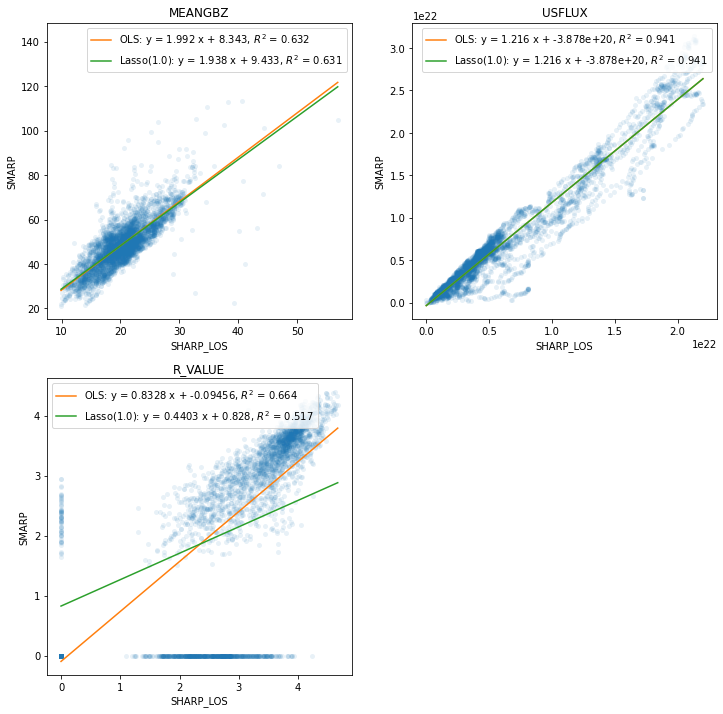

{'MEANGBZ': {'coef': 1.9920261748674042, 'intercept': 8.342889969768606},
 'USFLUX': {'coef': 1.216160520290385, 'intercept': -3.8777994451166115e+20},
 'R_VALUE': {'coef': 0.8327836641793915, 'intercept': -0.0945601961295528}}

In [8]:
keywords = ['MEANGBZ', 'USFLUX', 'R_VALUE']
alpha = 1
params = {}

plt.figure(figsize=(12,12))

for i in range(3):
    x, y = Xh[:,[i]], Xm[:,i]
    X = x.reshape(-1,1)
    lr = LR().fit(X, y)
    lasso = Lasso(alpha=alpha).fit(X, y)

    params[keywords[i]] = {
        'coef': lr.coef_.item(),
        'intercept': lr.intercept_,
    }

    plt.subplot(2,2,i+1)
    plt.plot(x, y, linestyle='', marker='o', markersize=5, markeredgecolor="None", alpha=0.1)

    xlim = np.array([X.min(), X.max()])
    lr_label = 'OLS: y = {:.4} x + {:.4}, $R^2$ = {:.3f}'.format(
        lr.coef_.item(),
        lr.intercept_,
        lr.score(X, y))
    plt.plot(xlim, lr.predict(xlim.reshape(-1, 1)), 'C1', label=lr_label)

    lasso_label = 'Lasso({:.1f}): y = {:.4} x + {:.4}, $R^2$ = {:.3f}'.format(
        alpha,
        lasso.coef_.item(),
        lasso.intercept_,
        lasso.score(X, y))
    plt.plot(xlim, lasso.predict(xlim.reshape(-1, 1)), 'C2', label=lasso_label)

    plt.xlabel('SHARP_LOS')
    plt.ylabel('SMARP')
    plt.title(keywords[i])
    plt.legend()
plt.savefig('outputs/linear_fit.png')
plt.show()
np.save('datasets/sharp2smarp.npy', params)
params

### Evaluate the linear fit on more SMARP and SHARP

In [9]:
def draw_pairplot():
    import seaborn as sns
    sharp2smarp = np.load('datasets/sharp2smarp.npy', allow_pickle=True).item()
    df_smarp = pd.read_csv('datasets/smarp/train.csv').sample(frac=0.01)
    df_sharp = pd.read_csv('datasets/sharp/train.csv').sample(frac=0.01)
    df_trans = df_sharp.copy()

    keys = ['R_VALUE', 'MEANGBZ', 'USFLUX']
    for k in keys:
        v = sharp2smarp[k]
        df_trans[k] = df_sharp[k] * v['coef'] + v['intercept']

    df = pd.concat((df_smarp, df_sharp, df_trans)).reset_index(drop=True)
    df = df[keys]
    df = df.assign(dataset=['SMARP'] * len(df_smarp) +
                           ['SHARP_LOS'] * len(df_sharp) +
                           ['SHARP_LOS_trans'] * len(df_trans))
    sns.pairplot(df, hue='dataset', corner=True,
                 kind='kde', # both diag and off-diag
                 #diag_kind = 'kde',
                 diag_kws = {'common_norm': False}, # kdeplot(univariate)
                 plot_kws = {'common_norm': False, 'levels': 5}, # kdeplot(bivariate)
    )
    plt.savefig('outputs/pairplot.png')
    plt.show()

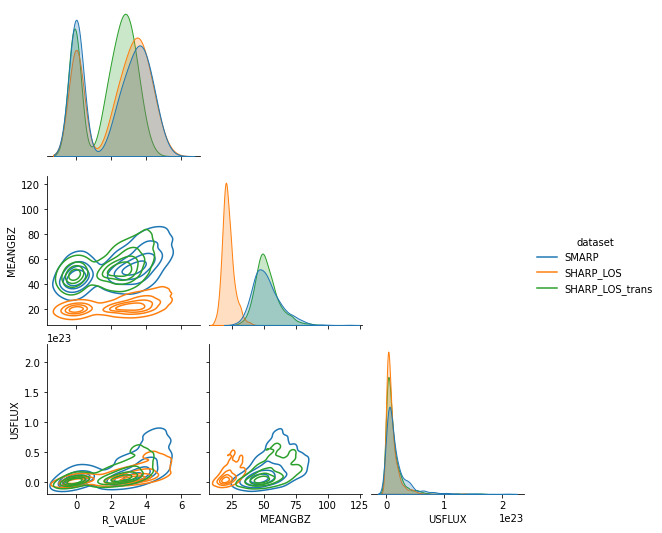

In [10]:
draw_pairplot()